In [6]:
import numpy as np

def basis_from_normal(n):
    """
    Orthonormal right-handed basis with z-axis = n.
    For n ≈ [0,0,1] this returns the identity matrix.
    """
    n = n / np.linalg.norm(n)

    # pick a reference axis that is NOT (anti)parallel to n
    if abs(n[0]) < 0.9:          # n not almost parallel to x → use x-axis
        ref = np.array([1.0, 0.0, 0.0])
    else:                        # otherwise fall back to y-axis
        ref = np.array([0.0, 1.0, 0.0])

    y = np.cross(n, ref)
    y /= np.linalg.norm(y)       # first in-plane axis
    x = np.cross(y, n)           # second (keeps right hand)
    R = np.column_stack((x, y, n))
    return R


In [7]:
R1 = basis_from_normal(np.array([ 0.2, 0.3, 0.925]))   # oblique plane
R2 = basis_from_normal(np.array([ 0.0, 0.0, 1.0]))     # horizontal plane
R3 = basis_from_normal(np.array([-0.9, 0.0, 0.435]))   # steep slope


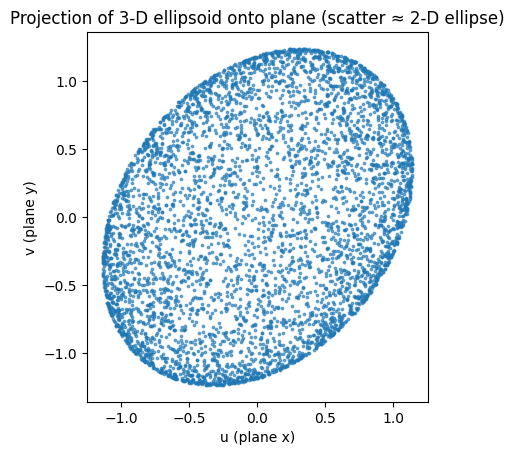

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def basis_from_normal(n, up=np.array([0., 0., 1.])):
    """
    Build a right‑handed orthonormal matrix whose third column is the
    unit normal n, and whose first column is the projection of `up` into
    the plane (no twist about n).
    """
    n = n / np.linalg.norm(n)
    if abs(np.dot(n, up)) > 0.999:          # n ∥ up  → pick a different ref
        up = np.array([0., 1., 0.])
    x = up - np.dot(up, n) * n
    x /= np.linalg.norm(x)
    y = np.cross(n, x)
    return np.column_stack((x, y, n))       # columns = axes (world <- local)

# --- parameters -------------------------------------------------------------
a, b, c = 1.5, 1.0, 0.75                    # ellipsoid semi‑axes
n_world = np.array([0.3, 0.4, 0.866])       # plane normal to project onto
n_world /= np.linalg.norm(n_world)
N_SAMPLES = 5000
rng = np.random.default_rng(0)

# --- sample points on ellipsoid surface ------------------------------------
v = rng.normal(size=(N_SAMPLES, 3))
v /= np.linalg.norm(v, axis=1, keepdims=True)      # unit vectors on sphere
pts = v * np.array([a, b, c])                      # scale to ellipsoid

# --- rotate so plane normal is world‑z, then drop z -------------------------
R = basis_from_normal(n_world)                     # world <- local
pts_rot = pts @ R.T                                # rotate into plane frame
pts_2d = pts_rot[:, :2]                            # project by dropping z

# --- plot -------------------------------------------------------------------
fig, ax = plt.subplots()
ax.scatter(pts_2d[:, 0], pts_2d[:, 1], s=3, alpha=0.6)
ax.set_aspect('equal', adjustable='box')
ax.set_title("Projection of 3‑D ellipsoid onto plane (scatter ≈ 2‑D ellipse)")
ax.set_xlabel("u (plane x)")
ax.set_ylabel("v (plane y)")
plt.show()


In [9]:
R2

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

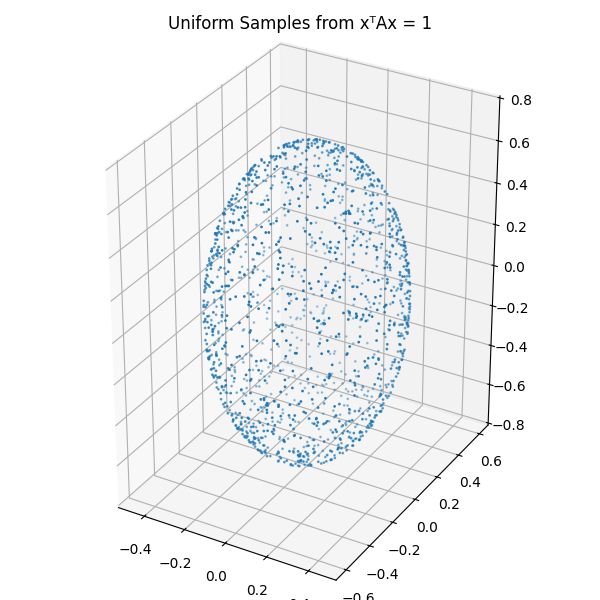

In [21]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl 

# Provided uniform ellipsoid surface sampler
def sample_ellipsoid_surface_uniform(A: torch.Tensor, n: int, oversample: float = 2.0):
    eigvals, eigvecs = torch.linalg.eigh(A)
    A_inv_sqrt = eigvecs @ torch.diag(1.0 / torch.sqrt(eigvals)) @ eigvecs.T

    accepted = []
    batch = int(n * oversample)

    while sum(p.shape[1] for p in accepted) < n:
        u = torch.randn(3, batch, dtype=torch.float64)
        u /= torch.norm(u, dim=0, keepdim=True)

        x = A_inv_sqrt @ u
        norm_A = torch.sqrt(torch.sum(x * (A @ x), dim=0))  # shape: (N,)
        x = x / norm_A.unsqueeze(0)

        weights = torch.norm(A_inv_sqrt @ u, dim=0)
        probs = 1.0 / weights**0
        probs /= probs.max()

        accept = torch.rand(batch) < probs
        accepted.append(x[:, accept])

    result = torch.cat(accepted, dim=1)[:, :n]
    return result

# Example ellipsoid matrix (semi-axes ~ 0.3, 0.2, 0.1 rotated)
Q = torch.tensor([[5.0, 1.0, 0.0],
                  [1.0, 3.0, 0.0],
                  [0.0, 0.0, 2.0]], dtype=torch.float64)

# Sample 2000 points
pts = sample_ellipsoid_surface_uniform(Q, 1600)

# Plot the result
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[0], pts[1], pts[2], s=1)
ax.set_title("Uniform Samples from xᵀAx = 1")
ax.set_box_aspect([1,1,1])
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
from scipy.spatial.transform import Rotation as R

view_angles = [
    [-90.0,    -90.0,     0.0],
    [180.0,     0.0,     90.0],
    [90.0,      0.0,      0.0],
    [-150.0,  -35.2643897,  45.0],
    [-30.0,   -35.2643897, -45.0],
    [150.0,    35.2643897,  45.0],
    [30.0,     35.2643897, -45.0]
]

rot_matrices = R.from_euler('ZYX', view_angles, degrees=True).as_matrix()


In [16]:
rot_matrices

array([[[ 2.22044605e-16,  0.00000000e+00, -1.00000000e+00],
        [ 1.00000000e+00,  2.22044605e-16,  2.22044605e-16],
        [ 2.22044605e-16, -1.00000000e+00,  0.00000000e+00]],

       [[ 2.22044605e-16, -1.00000000e+00,  0.00000000e+00],
        [-1.00000000e+00, -2.22044605e-16, -1.22464680e-16],
        [ 1.22464680e-16,  2.46519033e-32, -1.00000000e+00]],

       [[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  2.22044605e-16, -1.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  2.22044605e-16]],

       [[ 5.77350269e-01, -5.77350269e-01, -5.77350269e-01],
        [-4.08248290e-01, -8.16496581e-01,  4.08248290e-01],
        [-7.07106781e-01,  1.50494034e-10, -7.07106781e-01]],

       [[ 5.77350269e-01,  5.77350269e-01, -5.77350269e-01],
        [-4.08248290e-01,  8.16496581e-01,  4.08248290e-01],
        [ 7.07106781e-01,  1.50494034e-10,  7.07106781e-01]],

       [[ 5.77350269e-01, -5.77350269e-01,  5.77350269e-01],
        [-4.08

In [20]:
# Define desired volume targets
vol_02 = 0.02
vol_24 = 0.24

# Define raw triaxial ratios
A4_ratio = [1.0, 1.2, 1.5]     # 1:2:3
A5_ratio = [1.0, 1.5, 2.0]     # 1:1.5:2
A6_ratio = [1.0, 2.0, 3.0]     # 1:2:3

def scaled_triaxial_axes(ratios, target_vol):
    product = np.prod(ratios)
    scale = (target_vol / product) ** (1/3)
    scaled = [round(scale * r, 5) for r in ratios]
    return scaled

A4_02 = scaled_triaxial_axes(A4_ratio, vol_02)
A5_02 = scaled_triaxial_axes(A5_ratio, vol_02)

A4_24 = scaled_triaxial_axes(A4_ratio, vol_24)
A5_24 = scaled_triaxial_axes(A5_ratio, vol_24)

A6_02 = scaled_triaxial_axes(A6_ratio, vol_02)
A6_24 = scaled_triaxial_axes(A6_ratio, vol_24)


A4_02, A5_02, A4_24, A5_24, A6_02, A6_24


([0.22314, 0.26777, 0.33472],
 [0.18821, 0.28231, 0.37641],
 [0.51087, 0.61305, 0.76631],
 [0.43089, 0.64633, 0.86177],
 [0.14938, 0.29876, 0.44814],
 [0.342, 0.68399, 1.02599])

In [ ]:
([0.22314, 0.26777, 0.33472],
 [0.18821, 0.28231, 0.37641],
 [0.51087, 0.61305, 0.76631],
 [0.43089, 0.64633, 0.86177])